In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from matplotlib import pyplot as plt
from pretty_midi import PrettyMIDI, Instrument, Note
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import RandomAffine
import urllib.request

In [2]:
target_dir = 'bach-cello'
os.makedirs(target_dir, exist_ok=True)

urls = [
    "cs1-1pre.mid","cs1-2all.mid","cs1-3cou.mid","cs1-4sar.mid","cs1-5men.mid","cs1-6gig.mid",
    "cs2-1pre.mid","cs2-2all.mid","cs2-3cou.mid","cs2-4sar.mid","cs2-5men.mid","cs2-6gig.mid",
    "cs3-1pre.mid","cs3-2all.mid","cs3-3cou.mid","cs3-4sar.mid","cs3-5bou.mid","cs3-6gig.mid",
    "cs4-1pre.mid","cs4-2all.mid","cs4-3cou.mid","cs4-4sar.mid","cs4-5bou.mid","cs4-6gig.mid",
    "cs5-1pre.mid","cs5-2all.mid","cs5-3cou.mid","cs5-4sar.mid","cs5-5gav.mid","cs5-6gig.mid",
    "cs6-1pre.mid","cs6-2all.mid","cs6-3cou.mid","cs6-4sar.mid","cs6-5gav.mid","cs6-6gig.mid",
    'vs1-1ada.mid','vs1-2fug.mid', 'vs1-3sic.mid', 'vs1-4prs.mid', 'vp1-1al.mid', 'vp1-2ald.mid', 
    'vp1-3co.mid', 'vp1-4cod.mid', 'vp1-5sa.mid', 'vp1-6sad.mid', 'vp1-7tb.mid', 'vp1-8tbd.mid',
    'vs2-1gra.mid', 'vs2-2fug.mid', 'vs2-3and.mid', 'vs2-4alg.mid', 'vp2-1all.mid', 'vp2-2cou.mid',
    'vp2-3sar.mid', 'vp2-4gig.mid', 'vp2-5cha.mid', 'vs3-1ada.mid', 'vs3-2fug.mid', 'vs3-3lar.mid',
    'vs3-4alg.mid', 'vp3-1pre.mid', 'vp3-2lou.mid', 'vp3-3gav.mid', 'vp3-4min.mid', 'vp3-5bou.mid',
    'vp3-6gig.mid'
]
base_url = "http://www.jsbach.net/midi"

for file in tqdm(urls):
    url = f"{base_url}/{file}"
    file_path = os.path.join(target_dir, file)
    try:
        urllib.request.urlretrieve(url, file_path)
    except Exception as e:
        print(f"Failed to download {file}: {e}")

print("🚀 Done downloading all files!")

  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [00:29<00:00,  2.25it/s]

🚀 Done downloading all files!


In [16]:
class Config:
    # MIDI parameters
    pitch_range = 128  # MIDI pitch range (0-127)
    time_steps = 200   # Number of time steps in the piano roll
    velocity_bins = 32 # Number of velocity bins
    
    # Training parameters - UPDATED
    batch_size = 4     # Increased from 4
    num_epochs = 100   # More epochs with early stopping
    learning_rate = 2e-5  # Lower learning rate
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Diffusion parameters
    num_diffusion_steps = 1000
    beta_start = 1e-4
    beta_end = 0.02
    
    # Model parameters - REDUCED CAPACITY
    sample_size = (time_steps, pitch_range)
    in_channels = 1
    out_channels = 1
    layers_per_block = 1  # Reduced from 2
    block_out_channels = (32, 64, 96)  # Smaller than original
    down_block_types = (
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    )
    up_block_types = (
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
    dropout = 0.25
    norm_num_groups = 32

config = Config()

In [17]:
class MIDIDataset(Dataset):
    def __init__(self, midi_files, config):
        self.midi_files = midi_files
        self.config = config
        self.durations = []
        self.augment_transforms = RandomAffine(
            degrees=0,  # No rotation
            translate=(0.1, 0.1),  # Small translation in both dimensions
            scale=(0.9, 1.1)  # Small scaling
        )
        
    def augment(self, piano_roll):
        """Apply data augmentation to the piano roll"""
        augmented = self.augment_transforms(piano_roll)
        
        # Random time stretching (small)
        if torch.rand(1) > 0.7:
            stretch_factor = 0.9 + 0.2 * torch.rand(1)  # Between 0.9 and 1.1
            new_length = int(self.config.time_steps * stretch_factor)
            augmented = F.interpolate(
                augmented.unsqueeze(0), 
                size=(new_length, self.config.pitch_range),
                mode='bilinear'
            ).squeeze(0)
            # Pad or crop to maintain original size
            if new_length < self.config.time_steps:
                pad_amount = self.config.time_steps - new_length
                augmented = F.pad(augmented, (0, 0, 0, pad_amount))
            else:
                augmented = augmented[:, :self.config.time_steps, :]
        
        return augmented
    
    def __len__(self):
        return len(self.midi_files)
    
    def __getitem__(self, idx):
        midi_path = self.midi_files[idx]
        try:
            midi_data = PrettyMIDI(midi_path)
            total_duration = midi_data.get_end_time()
            
            # Calculate steps per second based on desired time_steps
            steps_per_second = self.config.time_steps / total_duration
            
            piano_roll = np.zeros((self.config.time_steps, self.config.pitch_range), dtype=np.float32)
            
            for instrument in midi_data.instruments:
                for note in instrument.notes:
                    start_step = int(note.start * steps_per_second)
                    end_step = int(note.end * steps_per_second)
                    pitch = note.pitch
                    velocity = note.velocity
                    
                    start_step = np.clip(start_step, 0, self.config.time_steps-1)
                    end_step = np.clip(end_step, 0, self.config.time_steps-1)
                    pitch = np.clip(pitch, 0, self.config.pitch_range-1)
                    
                    velocity_norm = velocity / 127.0
                    
                    for step in range(start_step, end_step + 1):
                        piano_roll[step, pitch] = velocity_norm
            
            piano_roll = torch.from_numpy(piano_roll).unsqueeze(0)
            
            # Apply data augmentation for small datasets
            if len(self.midi_files) < 100:
                if torch.rand(1) > 0.5:
                    piano_roll = self.augment(piano_roll)
                
                # Random masking
                if torch.rand(1) > 0.7:
                    mask_width = int(self.config.time_steps * (0.1 + 0.2 * torch.rand(1)))
                    mask_start = int((self.config.time_steps - mask_width) * torch.rand(1))
                    piano_roll[:, mask_start:mask_start+mask_width] = 0
            
            piano_roll = piano_roll * 2 - 1
            return piano_roll
        except Exception as e:
            print(f"Error processing {midi_path}: {e}")
            return torch.zeros((1, self.config.time_steps, self.config.pitch_range))
    
def load_midi_files(directory):
    midi_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.mid') or file.lower().endswith('.midi'):
                midi_files.append(os.path.join(root, file))
    return midi_files

In [18]:
def create_unet(config):
    return UNet2DModel(
        sample_size=config.sample_size,
        in_channels=config.in_channels,
        out_channels=config.out_channels,
        layers_per_block=config.layers_per_block,
        block_out_channels=config.block_out_channels,
        down_block_types=config.down_block_types,
        up_block_types=config.up_block_types,
        dropout=config.dropout,
        norm_num_groups=config.norm_num_groups
    )

def create_noise_scheduler(config):
    return DDPMScheduler(
        num_train_timesteps=config.num_diffusion_steps,
        beta_start=config.beta_start,
        beta_end=config.beta_end,
        beta_schedule="linear",
        prediction_type="epsilon"
    )

In [19]:
def train_loop(model, noise_scheduler, dataloader, optimizer, config):
    model.train()
    losses = []
    best_loss = float('inf')
    patience = 10
    no_improvement = 0
    
    initial_steps = 200
    noise_scheduler.num_train_timesteps = initial_steps
    step_increment = 200
    target_steps = config.num_diffusion_steps
    
    for epoch in range(config.num_epochs):
        if epoch % 20 == 0 and noise_scheduler.num_train_timesteps < target_steps:
            new_steps = min(noise_scheduler.num_train_timesteps + step_increment, target_steps)
            noise_scheduler.num_train_timesteps = new_steps
            print(f"\nIncreased diffusion steps to {new_steps}")
        
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{config.num_epochs}")
        
        for batch in progress_bar:
            batch = batch.to(config.device)
            noise = torch.randn_like(batch)
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, 
                (batch.shape[0],), device=config.device
            ).long()
            
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            noise_pred = model(noisy, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({
                "loss": loss.item(),
                "steps": noise_scheduler.num_train_timesteps 
            })
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        # Early stopping - NEW
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                break
        
        print(f"Epoch {epoch + 1} | Loss: {avg_loss:.4f} | Best: {best_loss:.4f} | Patience: {no_improvement}/{patience}")
    
    return losses

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.savefig("training_loss.png")
    plt.show()

In [20]:
def generate_midi(model, noise_scheduler, config, num_samples=1, output_dir = 'generated_midi'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate multiple samples
    for sample_idx in range(num_samples):
        noisy_piano_rolls = torch.randn(
            (1, config.in_channels, *config.sample_size),  # Generate one at a time
            device=config.device
        )
        
        # Denoising loop
        for t in tqdm(noise_scheduler.timesteps, desc=f"Generating sample {sample_idx+1}/{num_samples}"):
            with torch.no_grad():
                noise_pred = model(noisy_piano_rolls, t).sample
                noisy_piano_rolls = noise_scheduler.step(
                    noise_pred, t, noisy_piano_rolls
                ).prev_sample
        
        # Convert and save
        generated = (noisy_piano_rolls + 1) / 2
        piano_roll = generated[0,0].cpu().numpy()  # Remove batch and channel dims
        
        # Save MIDI
        output_path = os.path.join(output_dir, f"generated_{sample_idx}.mid")
        piano_roll_to_midi(piano_roll, output_path)
        print(f"Saved {output_path}")
        
        # Save visualization
        plt.figure(figsize=(12, 4))
        plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Generated Sample {sample_idx}")
        plt.xlabel("Time Steps")
        plt.ylabel("Pitch")
        plt.colorbar(label="Velocity")
        plt.savefig(os.path.join(output_dir, f"sample_{sample_idx}_plot.png"))
        plt.close()
    return generated.clamp(0, 1).cpu().numpy()

def piano_roll_to_midi(piano_roll, output_path, velocity_threshold=0.1):
    midi = PrettyMIDI()
    piano = Instrument(program=0)
    
    # Calculate step duration for exactly 1 minute
    total_duration = 60.0  # 60 seconds = 1 minute
    time_step_duration = total_duration / piano_roll.shape[0]
    
    for time_step in range(piano_roll.shape[0]):
        for pitch in range(piano_roll.shape[1]):
            velocity = piano_roll[time_step, pitch]
            
            if velocity > velocity_threshold:
                note = Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time_step * time_step_duration,
                    end=(time_step + 1) * time_step_duration
                )
                piano.notes.append(note)
    
    midi.instruments.append(piano)
    midi.write(output_path)

def generate_and_visualize(model, noise_scheduler, config, num_samples=3):
    samples = generate_midi(model, noise_scheduler, config, num_samples)
    
    os.makedirs("generated_midi", exist_ok=True)
    for i, sample in enumerate(samples):
        piano_roll = sample[0]  # Remove channel dim
        
        plt.figure(figsize=(12, 4))
        plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Generated Sample {i + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Pitch")
        plt.colorbar(label="Velocity")
        plt.savefig(f"generated_midi/sample_{i}_plot.png")
        plt.close()
        
        output_path = f"generated_midi/sample_{i}.mid"
        piano_roll_to_midi(piano_roll, output_path)
        print(f"Saved {output_path}")

Loaded 67 MIDI files

Model Parameters: 1.69M
Starting training...


Increased diffusion steps to 400


Epoch 1/100: 100%|██████████| 17/17 [00:07<00:00,  2.15it/s, loss=0.994, steps=400]


Epoch 1 | Loss: 1.0955 | Best: 1.0955 | Patience: 0/10


Epoch 2/100: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.855, steps=400]


Epoch 2 | Loss: 0.9092 | Best: 0.9092 | Patience: 0/10


Epoch 3/100: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.777, steps=400]


Epoch 3 | Loss: 0.7382 | Best: 0.7382 | Patience: 0/10


Epoch 4/100: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.502, steps=400]


Epoch 4 | Loss: 0.6209 | Best: 0.6209 | Patience: 0/10


Epoch 5/100: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.443, steps=400]


Epoch 5 | Loss: 0.5005 | Best: 0.5005 | Patience: 0/10


Epoch 6/100: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s, loss=0.39, steps=400] 


Epoch 6 | Loss: 0.4662 | Best: 0.4662 | Patience: 0/10


Epoch 7/100: 100%|██████████| 17/17 [00:06<00:00,  2.44it/s, loss=0.345, steps=400]


Epoch 7 | Loss: 0.3387 | Best: 0.3387 | Patience: 0/10


Epoch 8/100: 100%|██████████| 17/17 [00:06<00:00,  2.43it/s, loss=0.399, steps=400]


Epoch 8 | Loss: 0.2844 | Best: 0.2844 | Patience: 0/10


Epoch 9/100: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.177, steps=400]


Epoch 9 | Loss: 0.2472 | Best: 0.2472 | Patience: 0/10


Epoch 10/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.21, steps=400] 


Epoch 10 | Loss: 0.2195 | Best: 0.2195 | Patience: 0/10


Epoch 11/100: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.237, steps=400]


Epoch 11 | Loss: 0.2279 | Best: 0.2195 | Patience: 1/10


Epoch 12/100: 100%|██████████| 17/17 [00:07<00:00,  2.28it/s, loss=0.153, steps=400]


Epoch 12 | Loss: 0.1706 | Best: 0.1706 | Patience: 0/10


Epoch 13/100: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.124, steps=400]


Epoch 13 | Loss: 0.1772 | Best: 0.1706 | Patience: 1/10


Epoch 14/100: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.205, steps=400]


Epoch 14 | Loss: 0.1673 | Best: 0.1673 | Patience: 0/10


Epoch 15/100: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.134, steps=400]


Epoch 15 | Loss: 0.1774 | Best: 0.1673 | Patience: 1/10


Epoch 16/100: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.155, steps=400]


Epoch 16 | Loss: 0.1717 | Best: 0.1673 | Patience: 2/10


Epoch 17/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.0821, steps=400]


Epoch 17 | Loss: 0.1541 | Best: 0.1541 | Patience: 0/10


Epoch 18/100: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.0894, steps=400]


Epoch 18 | Loss: 0.1423 | Best: 0.1423 | Patience: 0/10


Epoch 19/100: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.117, steps=400]


Epoch 19 | Loss: 0.1571 | Best: 0.1423 | Patience: 1/10


Epoch 20/100: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s, loss=0.0888, steps=400]


Epoch 20 | Loss: 0.1490 | Best: 0.1423 | Patience: 2/10

Increased diffusion steps to 600


Epoch 21/100: 100%|██████████| 17/17 [00:07<00:00,  2.26it/s, loss=0.117, steps=600] 


Epoch 21 | Loss: 0.1223 | Best: 0.1223 | Patience: 0/10


Epoch 22/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.0801, steps=600]


Epoch 22 | Loss: 0.1126 | Best: 0.1126 | Patience: 0/10


Epoch 23/100: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s, loss=0.132, steps=600] 


Epoch 23 | Loss: 0.1291 | Best: 0.1126 | Patience: 1/10


Epoch 24/100: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.153, steps=600] 


Epoch 24 | Loss: 0.1254 | Best: 0.1126 | Patience: 2/10


Epoch 25/100: 100%|██████████| 17/17 [00:06<00:00,  2.43it/s, loss=0.227, steps=600] 


Epoch 25 | Loss: 0.1082 | Best: 0.1082 | Patience: 0/10


Epoch 26/100: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.0528, steps=600]


Epoch 26 | Loss: 0.1157 | Best: 0.1082 | Patience: 1/10


Epoch 27/100: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s, loss=0.128, steps=600] 


Epoch 27 | Loss: 0.0906 | Best: 0.0906 | Patience: 0/10


Epoch 28/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.08, steps=600]  


Epoch 28 | Loss: 0.0824 | Best: 0.0824 | Patience: 0/10


Epoch 29/100: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s, loss=0.104, steps=600] 


Epoch 29 | Loss: 0.1066 | Best: 0.0824 | Patience: 1/10


Epoch 30/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.0629, steps=600]


Epoch 30 | Loss: 0.0875 | Best: 0.0824 | Patience: 2/10


Epoch 31/100: 100%|██████████| 17/17 [00:07<00:00,  2.39it/s, loss=0.193, steps=600] 


Epoch 31 | Loss: 0.1050 | Best: 0.0824 | Patience: 3/10


Epoch 32/100: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s, loss=0.139, steps=600] 


Epoch 32 | Loss: 0.1136 | Best: 0.0824 | Patience: 4/10


Epoch 33/100: 100%|██████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.119, steps=600] 


Epoch 33 | Loss: 0.0925 | Best: 0.0824 | Patience: 5/10


Epoch 34/100: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.0762, steps=600]


Epoch 34 | Loss: 0.1086 | Best: 0.0824 | Patience: 6/10


Epoch 35/100: 100%|██████████| 17/17 [00:07<00:00,  2.43it/s, loss=0.0538, steps=600]


Epoch 35 | Loss: 0.1234 | Best: 0.0824 | Patience: 7/10


Epoch 36/100: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s, loss=0.11, steps=600]  


Epoch 36 | Loss: 0.0953 | Best: 0.0824 | Patience: 8/10


Epoch 37/100: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s, loss=0.055, steps=600] 


Epoch 37 | Loss: 0.1048 | Best: 0.0824 | Patience: 9/10


Epoch 38/100: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s, loss=0.143, steps=600] 



Early stopping at epoch 38


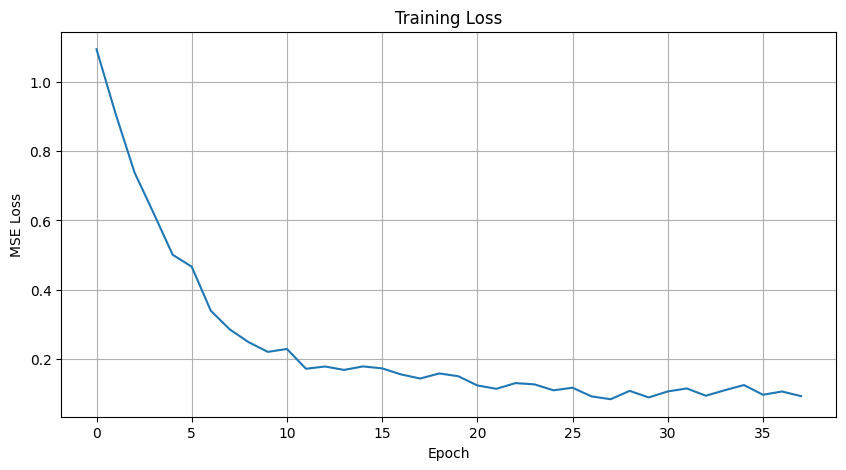

Generating sample 1/5: 100%|██████████| 1000/1000 [00:19<00:00, 50.13it/s]


Saved generated_midi\generated_0.mid


Generating sample 2/5: 100%|██████████| 1000/1000 [00:19<00:00, 50.93it/s]


Saved generated_midi\generated_1.mid


Generating sample 3/5: 100%|██████████| 1000/1000 [00:19<00:00, 51.80it/s]


Saved generated_midi\generated_2.mid


Generating sample 4/5: 100%|██████████| 1000/1000 [00:19<00:00, 51.10it/s]


Saved generated_midi\generated_3.mid


Generating sample 5/5: 100%|██████████| 1000/1000 [00:19<00:00, 51.05it/s]


Saved generated_midi\generated_4.mid


In [21]:
def main():
    midi_dir = "bach-cello"
    midi_files = load_midi_files(midi_dir)
    
    if not midi_files:
        print("No MIDI files found!")
        return
    
    print(f"Loaded {len(midi_files)} MIDI files")
    
    dataset = MIDIDataset(midi_files, config)
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    
    model = create_unet(config).to(config.device)
    noise_scheduler = create_noise_scheduler(config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    
    # NEW: Print model info
    print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    print("Starting training...\n")
    
    losses = train_loop(model, noise_scheduler, dataloader, optimizer, config)
    plot_loss(losses)
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    num_samples = 5  # Change this to generate more/fewer samples
    generate_midi(model, noise_scheduler, config, num_samples=num_samples)

if __name__ == "__main__":
    main()